# Imports

In [1]:
#@title Mounting Google Drive
from google.colab import files
from google.colab import drive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Y4/Research \Project

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Y4/Research Project


In [2]:
#@title Importing libraries
import numpy as np
from numpy.random import RandomState
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
!pip install -U seaborn

from openpyxl import load_workbook
import datetime
import statistics

!pip install simpy
import simpy 

import scipy
import warnings
import scipy.stats as st
import statsmodels as sm

from statsmodels.distributions.empirical_distribution import ECDF
import random
from bisect import bisect_left

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [0]:
#@title Auxiliary functions

# common
def plot_two_lists(nameX, x, nameY, y, kind_type, height=7):
  # plotting the graph
  df = pd.DataFrame()
  df[nameX] = x
  df[nameY] = y
  
  sns.set_style("white")  
  sns.relplot(x=nameX, y=nameY, data=df, kind=kind_type, 
              height=height, palette="b", color="#ff4f4f")
  
def print_stats(local_list):
  print("Max:", max(local_list))
  print("Min:", min(local_list))
  
  print("\nMean: %.2f" % statistics.mean(local_list))
  print("Median:", statistics.median(local_list))
#   print("Median High:", statistics.median_high(local_list))
#   print("Median Low:", statistics.median_low(local_list))
  try:
    print("Mode:", statistics.mode(local_list))
  except Exception: # in case all values are equally chanced
    print("Mode: no mode.")
  
# for analysing bug creation
def count_vs_days(days_between_bugs):
  # getting the count for distibution "Count vs Days"
  new_days_between_bugs = []
  count_repeated_days = []
  # making the first append
  new_days_between_bugs.append(days_between_bugs[0])
  temp_count = 1
  count_repeated_days.append(temp_count)
  # continue
  for i in range(1, len(days_between_bugs), 1): # starting with 1 not 0, as the first value is already appended
    if days_between_bugs[i] == new_days_between_bugs[-1]:
      temp_count += 1
      count_repeated_days[-1] = temp_count
    else:
      new_days_between_bugs.append(days_between_bugs[i])
      temp_count = 1
      count_repeated_days.append(temp_count)
  
  return count_repeated_days, new_days_between_bugs

# Playing with the data

## Analysing Alert Count

Max: 568.0
Min: 0.0

Mean: 0.67
Median: 0.0
Mode: 0.0
Percentage of non-zero values: 9.96%

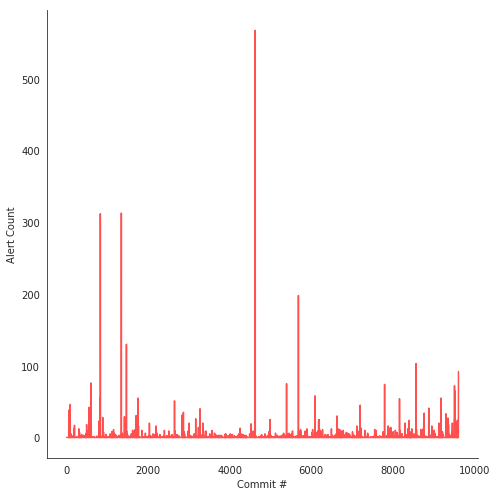

In [4]:
#@title Analysing alert counts
def show_alert_counts():
  workbook_git = load_workbook('data/git-commits.xlsx')
  sheet_git = workbook_git['Records'] # print(workbook_git.sheetnames)

  list_of_count_alerts = []
  non_zero_values = 0
  for count_alerts in sheet_git['G']: # column G is for Alert Count
    if count_alerts != sheet_git['G1']:
      if count_alerts.value != -1: # ignoring -1, which is irrelevant
        list_of_count_alerts.append(count_alerts.value)
      
      # getting the non-zero values
      if count_alerts.value > 0:
        non_zero_values += 1
  
  print_stats(list_of_count_alerts)
  
  plot_two_lists("Commit #", range(len(list_of_count_alerts)), "Alert Count", list_of_count_alerts, "line")
  
  percentage_non_zero_values = (non_zero_values / len(list_of_count_alerts)) * 100
  print("Percentage of non-zero values: %.2f" % percentage_non_zero_values, end="%")
  
show_alert_counts()

In [0]:
# checking the developers involved:
# check the developers in overview who made a fix to bugs

Kludges: 958 which is 10.597345132743364 %

9040
Max: 568.0
Min: 0.0

Mean: 0.71
Median: 0.0
Mode: 0.0


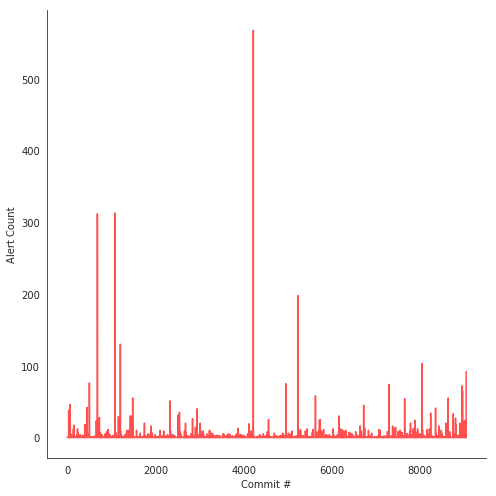

In [6]:
#@title Analysing alert counts, kludges and 0 contribution commits
# pd.DataFrame(list_of_count_alerts).quantile([0.25,0.5,0.75])

# set the threshold to be (# of lines changed / # of alerts) > eg 100
# meaning every 100 lines were changed without an error
# avoid division by 0 lol

# kludge = 0
# for count_alerts in list_of_count_alerts:
#   if count_alerts:
#     pass

# make a distribution PER developer that he will commit a kludge or a fix






alert_count_threshold = 0 # lines before an error
# major_commit_threshold = 100

def show_alert_counts_():
  workbook = load_workbook('data/git-commits.xlsx')
  sheet = workbook['Records']

  list_of_count_alerts = []
  
  kludges = 0
#   significant_commits = 0

  # starting with index 2 as 0 represents overview of all values and 1 stands for the heading
  for i in range(2, len(sheet['G'])+1, 1):
    # G for Alert Count, I for Lines Added
    # ignore 0 contribution commits
    if sheet['G'+str(i)].value != -1 and sheet['I'+str(i)].value > 0:
      list_of_count_alerts.append(sheet['G'+str(i)].value)
      
      if sheet['G'+str(i)].value != 0:
        quality_control = sheet['I'+str(i)].value / sheet['G'+str(i)].value # lines per alert
        
        if quality_control > alert_count_threshold:
          kludges += 1
          
#       if sheet['I'+str(i)].value > major_commit_threshold:
#         major_commits += 1
  
  
#   print("Major commits:", major_commits, "where kludges", (kludges / major_commits * 100), "%")
  print("Kludges:", kludges, "which is", (kludges / len(list_of_count_alerts) * 100), "%\n")
  
  print(len(list_of_count_alerts))
  print_stats(list_of_count_alerts)
  plot_two_lists("Commit #", range(len(list_of_count_alerts)), "Alert Count", list_of_count_alerts, "line")
  
show_alert_counts_()

## Modelling Bug Creation

In [0]:
#@title Do you want to use float days for better precision?
use_float_days = True #@param {type:"boolean"}

(Number of days to create a new bug)
Max: 126.2229050925926
Min: 0.0

Mean: 3.48
Median: 1.1083912037037038
Mode: 0.0


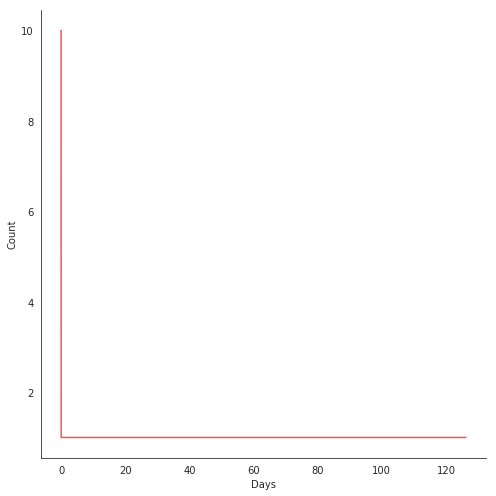

In [8]:
#@title Analysing bug creation: consecutive "creation_date"
def show_bug_creation():
  workbook = load_workbook('data/bugzilla-overview.xlsx')
  sheet = workbook['Bugs Overview'] # print(workbook.sheetnames)

  # getting the bug creation dates
  bug_creation_dates = []
  for bug_creation_date in sheet['I']: # column I is for Creation Time
    if bug_creation_date != sheet['I1']:
      date_formatted = datetime.datetime.strptime(bug_creation_date.value,"%Y-%m-%dT%H:%M:%SZ")
      bug_creation_dates.append(date_formatted)
  bug_creation_dates.sort() # needs sorting
  
  # getting the days in between consecutive bugs
  days_between_bug_creation = []
  for i in range(len(bug_creation_dates)-1):
    time_delta = bug_creation_dates[i+1] - bug_creation_dates[i]
    
    if use_float_days == True:
      days_as_a_float = time_delta.days + (time_delta.seconds / (24*60*60) )
    else:
      days_as_a_float = time_delta.days
    
    days_between_bug_creation.append(days_as_a_float)
#   print(days_between_bug_creation)
  return_value = days_between_bug_creation.copy()
  days_between_bug_creation.sort() # needed to model the distribution
  
  print("(Number of days to create a new bug)")
  print_stats(days_between_bug_creation)
  
  count_repeated_days, new_days_between_bug_creation = count_vs_days(days_between_bug_creation)
  plot_two_lists('Days', new_days_between_bug_creation, 'Count', count_repeated_days, 'line')
  
#   print("\n", len(return_value), return_value)
  return return_value
  
  
global_created_bugs = show_bug_creation() 

In [0]:
#@markdown Playing with the code
# workbook_bug_overview = load_workbook('data/bugzilla-overview.xlsx')
# sheet_bug_overview = workbook_bug_overview['Bugs Overview']
# # print(workbook_bug_overview.sheetnames)

# # getting the bug creation dates
# bug_creation_dates = []
# for bug_creation_date in sheet_bug_overview['I']: # column I is for Creation Time
#   if bug_creation_date != sheet_bug_overview['I1']:
#     bug_creation_dates.append(bug_creation_date.value)
# bug_creation_dates.sort()
# bug_creation_dates

#-------------------------------------------------------------------------------

# test_two = list_of_count_alerts
# test_three = []
# for date in test_two:
#   date_formatted = datetime.datetime.strptime(date,"%Y-%m-%dT%H:%M:%SZ")
#   test_three.append(date_formatted)
  
# test_three

#-------------------------------------------------------------------------------

# av_days = []
# for i in range(len(test_three)-1):
#   time_delta = test_three[i+1]-test_three[i]
#   av_days.append(time_delta.days)
# av_days

#-------------------------------------------------------------------------------

# print("%.2f" % (sum(av_days) / len(av_days)))

#-------------------------------------------------------------------------------

# av_days_fake = []
# days_temp = []

# av_days_fake = av_days

# av_days_fake.append(10)
# av_days_fake.append(43)
# av_days_fake.append(27)
# av_days_fake.append(27)

# days_temp = av_days_fake
# days_temp.sort()
# days_temp

#-------------------------------------------------------------------------------

# test_four = []
# count = []

# # making the first append
# test_four.append(days_temp[0])
# temp_count = 1
# count.append(temp_count)
# # continue
# for i in range(1, len(days_temp), 1): # starting with 1 not 0, as the first value is already appended
#   if days_temp[i] == test_four[-1]:
#     temp_count += 1
#     count[-1] = temp_count
#   else:
#     test_four.append(days_temp[i])
#     temp_count = 1
#     count.append(temp_count)
    
# # checking the results
# print("C:", len(count), "T:", len(test_four))
# # for i in range(len(test_four)):
# #   print(count[i], test_four[i])

#-------------------------------------------------------------------------------

# df = pd.DataFrame()
# df['Count'] = count
# df['Days'] = test_four
# sns.relplot(x='Days', y='Count', data=df, kind="line")
# plt.show()

#-------------------------------------------------------------------------------

# test = list_of_count_alerts

# # indices = sorted(range(len(test)), key=lambda k: test[k], reverse = True)
# # for i in test:
# #   print(i[0:4])
# # test.sort(key=lambda k: indices[k])
# test.sort()
# test

## Modelling Bug Termination

-1: 837 2006-08-17 13:21:17 2006-08-17 19:41:38
-1: 901 2005-12-27 16:10:25 2005-12-28 00:58:34
-1: 1002 2005-03-21 02:05:43 2005-03-21 07:53:53

(Number of days to fix a bug)
Max: 5968
Min: 0

Mean: 931.25
Median: 780.0
Mode: 0


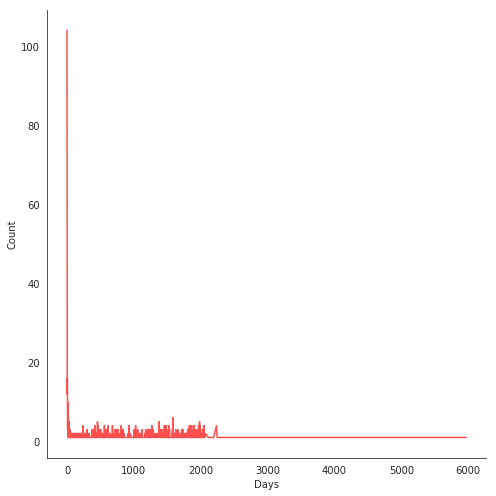

In [10]:
#@title Analysing bug fixation: "creation_date - last_change_time"
def show_bug_fixation_():
  workbook = load_workbook('data/bugzilla-overview.xlsx')
  sheet = workbook['Bugs Overview'] # print(workbook.sheetnames)

  # getting the bug termination dates: depending on Status and Is Open
  bug_fixation_dates = []
  for i in range(2, len(sheet['K'])+1, 1): # starting with index 2 as 0 represents overview of all values and 1 stands for the heading
#     print(sheet['O'+str(i)].value, sheet['J'+str(i)].value)
    if sheet['O'+str(i)].value == "RESOLVED" and sheet['J'+str(i)].value == "false": # K for Last Changed Time, O for Status, J for Is Open
      date_formatted_lct = datetime.datetime.strptime(sheet['K'+str(i)].value,"%Y-%m-%dT%H:%M:%SZ") # add the corresponding date
      date_formatted_ct = datetime.datetime.strptime(sheet['I'+str(i)].value,"%Y-%m-%dT%H:%M:%SZ") 
      time_delta = date_formatted_lct - date_formatted_ct
      if time_delta.days != -1:
        bug_fixation_dates.append(time_delta.days)
      else:
        print("-1:",i, date_formatted_lct, date_formatted_ct)
  return_value = bug_fixation_dates.copy()
  bug_fixation_dates.sort() # needed to model the distribution
    
  print("\n(Number of days to fix a bug)")
  print_stats(bug_fixation_dates)
        
  count_repeated_days, new_days_between_bugs = count_vs_days(bug_fixation_dates)
  plot_two_lists('Days', new_days_between_bugs, 'Count', count_repeated_days, 'line')
  
  return return_value
  
#   df = pd.DataFrame()
#   df["Days"] = [str(x) for x in new_days_between_bugs]
#   df["Count"] = count_repeated_days
#   sns.set(rc={'figure.figsize':(15, 100)})
#   sns.set_style("white")
#   sns.relplot(x="Days", y="Count", data=df, kind="scatter")
#   plt.show()
  
global_fixed_bugs_ = show_bug_fixation_() 
# print(global_fixed_bugs_)

(Number of days to fix a bug)
Max: 186.30189814814815
Min: 0.0

Mean: 3.11
Median: 0.0
Mode: 0.0


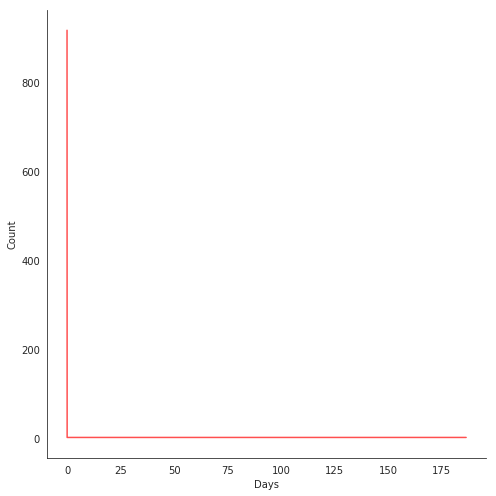

In [11]:
#@title Analysing bug fixation: consecutive "last_change_time"
def show_bug_fixation():
  workbook = load_workbook('data/bugzilla-overview.xlsx')
  sheet = workbook['Bugs Overview'] # print(workbook.sheetnames)
  
  # getting the bug termination dates: depending on Status and Is Open
  bug_fixation_dates = []
  for i in range(2, len(sheet['K'])+1, 1): # starting with index 2 as 0 represents overview of all values and 1 stands for the heading
    if sheet['O'+str(i)].value == "RESOLVED" and sheet['J'+str(i)].value == "false": # K for Last Changed Time, O for Status, J for Is Open
      date_formatted = datetime.datetime.strptime(sheet['K'+str(i)].value,"%Y-%m-%dT%H:%M:%SZ")
      bug_fixation_dates.append(date_formatted)
  bug_fixation_dates.sort() # needs sorting
#   print(bug_fixation_dates)
  
  # getting the days in between consecutive bugs
  days_between_bug_fixation = []
  for i in range(len(bug_fixation_dates)-1):
    time_delta = bug_fixation_dates[i+1] - bug_fixation_dates[i]
    if use_float_days == True:
      days_as_a_float = time_delta.days + (time_delta.seconds / (24*60*60) )
    else:
      days_as_a_float = time_delta.days
    
    days_between_bug_fixation.append(days_as_a_float)
  return_value = days_between_bug_fixation.copy()
  days_between_bug_fixation.sort() # needed to model the distribution
    
  print("(Number of days to fix a bug)")
  print_stats(days_between_bug_fixation)
        
  count_repeated_days, new_days_between_bugs = count_vs_days(days_between_bug_fixation)
  plot_two_lists('Days', new_days_between_bugs, 'Count', count_repeated_days, 'line')
  
  return return_value
    
global_fixed_bugs = show_bug_fixation() 
# print(len(global_fixed_bugs), global_fixed_bugs)

In [12]:
# third one: use history to track "OPEN" - "CLOSED"
#@title Analysing bug resolution: "ASSIGNED" - "CLOSED"
def get_resolved_reopened_status():
  workbook = load_workbook('data/bugzilla-history.xlsx')
  sheet = workbook['Bugs History']
  
#   # getting unique bugs
#   all_bugs = []
#   for i in range(2, len(sheet['B'])+1, 1): all_bugs.append(sheet['B'+str(i)].value)
#   all_bugs = list(set(all_bugs))
  
#   new_all_bugs = []
#   for i in all_bugs:
#     new_all_bugs.append([i, 0, 0])
  
  # getting unique tuples: bug OPEN and CLOSED
  all_bugs_tuples = [] # B for bugID, E for date, F for added
  for i in range(2, len(sheet['B'])+1, 1):
    # getting ESOLVED / REOPEN status
    if sheet['F'+str(i)].value == "RESOLVED" or sheet['F'+str(i)].value == "REOPENED":
#       all_bugs.remove(sheet['B'+str(i)].value)
      all_bugs_tuples.append([int(sheet['B'+str(i)].value), 
                    sheet['E'+str(i)].value,
                    sheet['F'+str(i)].value])
  
#     if sheet['F'+str(i)].value == "RESOLVED":
#       index = all_bugs.index(sheet['B'+str(i)].value)
#       entry = new_all_bugs[index]
#       entry[1] = 1
      
#     if sheet['G'+str(i)].value == "cc":
#       index = all_bugs.index(sheet['B'+str(i)].value)
#       entry = new_all_bugs[index]
#       entry[2] = 1

#   for i in all_bugs_tuples:
#     print(i)
    
#   all_bugs_temp = [x[0] for x in new_all_bugs]
#   for i in range(len(new_all_bugs)):
#     print(new_all_bugs[i])
#     print(all_bugs_temp[i])
  
  return all_bugs_tuples


def get_dif_start_end(start, end):
  df_start = datetime.datetime.strptime(start[1],"%Y-%m-%dT%H:%M:%SZ")
  df_end = datetime.datetime.strptime(end[1],"%Y-%m-%dT%H:%M:%SZ")
  time_delta = df_end - df_start

  days_as_a_float = 0
  if use_float_days == True:
    days_as_a_float = time_delta.days + (time_delta.seconds / (24*60*60) )
  else:
    days_as_a_float = time_delta.days
  
  return days_as_a_float


def get_resolution_periods(history):
  workbook = load_workbook('data/bugzilla-overview.xlsx')
  sheet = workbook['Bugs Overview']
  
#   dif = 2
#   for i in range(2, len(sheet['B'])+1, 1):
#     if sheet['O'+str(i)].value != "RESOLVED":
#       dif += 1
#     elif sheet['B'+str(i)].value == history[i-dif][0]:
#       print("Good")
#     else:
#       print("BAD", i, sheet['B'+str(i)].value, history[i-dif][0])

  all_bugs = [] # B for bugID, I for creation time
  for i in range(2, len(sheet['B'])+1, 1):
    # checking for duplicate data, which shouldn't be the case but appears for some reason!!
    can_add = True
    if all_bugs: # if list is non-empty 
      if int(sheet['B'+str(i)].value) == all_bugs[-1][0]:
        can_add = False
    
    if sheet['O'+str(i)].value in ["NEW", "ASSIGNED", ''] or sheet['O'+str(i)].value is None: 
      can_add = False
    
    if can_add == True:
      all_bugs.append([int(sheet['B'+str(i)].value), 
                      sheet['I'+str(i)].value,
                      sheet['M'+str(i)].value])
  
  all_bugs.sort(key=lambda tup: tup[0])
  
  history.sort(key=lambda tup: tup[1]) # sort by time
  history.sort(key=lambda tup: tup[0]) # sort by bugID
  
  # check all tuples are "RESOLVED -> REOPENED -> RESOLVED ..."
  indeces_to_delete = []
  for i in range(1, len(history), 1):
    if history[i][0] == history[i-1][0] and history[i][2] == "RESOLVED" and history[i-1][2] == "RESOLVED":
      print("*** ERROR, two resolved:", history[i], history[i-1])      
    if not history[i][0] == history[i-1][0] and history[i-1][2] == "REOPENED":
#       print("REOPENED but never RESOLVED", history[i-1])
      indeces_to_delete.append(i)
  # delete REOPENED but not RESOLVED afterwards
  indeces_to_delete.sort(reverse = True)
  for i in indeces_to_delete:
    del history[i-1]
    
  for i in range(1, len(all_bugs), 1):
    if all_bugs[i][0] == all_bugs[i-1][0]:
      print(all_bugs[i], all_bugs[i-1])
#         del all_bugs[i]
        
#         can_break = False
#         break
      
#       if i == len(all_bugs):
#         can_break = True
    
#     if can_break == True:
#       break
  
  all_periods = []
  for i in range(len(all_bugs)):
    start = all_bugs[0]
    end = history[0]
#     print(start, end, len(all_bugs), len(history))

    if end[2] == "RESOLVED" and start[0] == end[0]:
      days_as_a_float = get_dif_start_end(start, end)
      all_periods.append(days_as_a_float)
#       print(days_as_a_float)

      del history[0]
      if len(history) > 1:
        while history[0][0] == all_bugs[0][0] and history[0][2] == "REOPENED":
          start = history[0] # reopened
          end = history[1] # resolved

          if end[0] == start[0] and end[2] == "RESOLVED":
            days_as_a_float = get_dif_start_end(start, end)
            all_periods.append(days_as_a_float)
#             print(days_as_a_float)

            del history[0]
            del history[0]

          else:
            print("*1* ERROR:", start, end)

            del history[0]
          
          if len(history) > 1:
            continue
          else:
            break

      del all_bugs[0]  


    else:
      print("*2* ERROR:", start, end)
#       break
      del all_bugs[0]
  
  print("Remained:", len(all_bugs), len(history), "\n")
  
  return all_periods
  
  

def show_res_time(list_of_res):
  print("(Number of days to resolve a bug)")
  print_stats(list_of_res)

#   count_repeated_days, new_days_between_bugs = count_vs_days(list_of_res)
#   plot_two_lists('Days', new_days_between_bugs, 'Count', count_repeated_days, 'line')
    
get_resolved_reopened_status = get_resolved_reopened_status()
global_resolution_time = get_resolution_periods(get_resolved_reopened_status)
show_res_time(global_resolution_time)

*2* ERROR: [36670, '2005-09-15T15:05:27Z', ''] [36712, '2005-10-22T20:28:36Z', 'RESOLVED']
Remained: 0 0 

(Number of days to resolve a bug)
Max: 5585.7567476851855
Min: -0.0202430555555555

Mean: 225.85
Median: 12.613541666666666
Mode: no mode.


# Bug Simulation

## Fitting the distributions

In [0]:
#@title Using empirical model by default (tick for theoretical)
use_theoretical_models = False #@param {type:"boolean"}

# initialise values
bug_creation_best_fit, bug_creation_bf_params = st.norm, st.norm.fit(global_created_bugs)
bug_fixation_best_fit, bug_fixation_bf_params = st.norm, st.norm.fit(global_fixed_bugs)

In [0]:
#@title Checking whether theoretical distributions can fit
# Distributions to check
DISTRIBUTIONS = [        
    st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
    st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
    st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
    st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
    st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
    st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
    st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
    st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
    st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
    st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy,
    st.bernoulli, st.binom, st.boltzmann, st.dlaplace, st.geom, st.hypergeom, 
    st.logser, st.nbinom, st.planck, st.poisson, st.randint, st.skellam, st.zipf
]

class CheckForBestFit():
  # Create models from data
  def best_fit_distribution(self, data):
    # Best holders
    best_ks = []

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
      # Try to fit the distribution
      try:
        # Ignore warnings from data that can't be fit
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')

            # fit dist to data
            params = distribution.fit(data)

            # Separate parts of parameters
            arg = params[:-2]
            loc = params[-2]
            scale = params[-1]

            if len(params)==3:
              model_data = distribution.rvs(arg, loc=loc, scale=scale, size=len(data))
            elif len(params)==4:
              model_data = distribution.rvs(params[0], params[1], loc=loc, scale=scale, size=len(data))
            elif len(params)==5:
              model_data = distribution.rvs(params[0], params[1], params[2], loc=loc, scale=scale, size=len(data))
            elif len(params)==6:
              model_data = distribution.rvs(params[0], params[1], params[2], params[3], loc=loc, scale=scale, size=len(data))
            else:
              model_data = distribution.rvs(loc=loc, scale=scale, size=len(data))
            ks_stats, ks_p = st.ks_2samp(data, model_data)
            
            ks_t_s, ks_t_p = st.kstest(x, distribution.name, args=params)
#             print(distribution.name, ks_stats, ks_p, )
            best_ks.append([ks_stats, ks_p, distribution, ks_t_p])

      except Exception:
        pass
    
    best_t_p = [0,0]
    best_p = [0,0]
    best_s = [0,0]
    best_d = [st.norm, st.norm]
    
    for s,p,d,t_p in best_ks:
      if p > best_p[0]:
        best_t_p[0] = t_p
        best_p[0] = p
        best_s[0] = s
        best_d[0] = d
      
      if t_p > best_t_p[1]:
        best_t_p[1] = t_p
        best_p[1] = p
        best_s[1] = s
        best_d[1] = d
    
    print("BEST by sample:",best_d[0].name, best_s[0],best_p[0],best_t_p[0])
    print("BEST by continuous:",best_d[1].name, best_s[1],best_p[1],best_t_p[1])

  def __init__(self, data_to_load):
    data = pd.Series(data_to_load)
    self.best_fit_distribution(data)

    


if use_theoretical_models == True:
  print("Bug creation:")    
  CheckForBestFit(global_created_bugs)

  print("\nBug fixation:") 
  CheckForBestFit(global_fixed_bugs)

In [0]:
#@title Best fit function

# # Distributions to check
# DISTRIBUTIONS = [        
#     st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
#     st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
#     st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
#     st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
#     st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
#     st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
#     st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
#     st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
#     st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
#     st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
# ]

# DISTRIBUTIONS = [        
#     st.bernoulli, st.binom, st.boltzmann, st.dlaplace, st.geom, st.hypergeom, 
#     st.logser, st.nbinom, st.planck, st.poisson, st.randint, st.skellam, st.zipf
# ]

class FindBestFit():
#     def check_chisquare(self, p, degrees_of_freedom):
#         return st.chi2.cdf(p, degrees_of_freedom)
    
    # Create models from data
    def best_fit_distribution(self, data, bins=200, ax=None):
        """Model data by finding best fit distribution to data"""
        # Get histogram of original data
        y, x = np.histogram(data, bins=bins, density=True)
        x = (x + np.roll(x, -1))[:-1] / 2.0

        # Best holders
        best_distribution = st.norm
        best_params = (0.0, 1.0)
        best_sse = np.inf
        best_chisquare = 0
        
        # Estimate distribution parameters from data
        for distribution in DISTRIBUTIONS:

            # Try to fit the distribution
            try:
                # Ignore warnings from data that can't be fit
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore')

                    # fit dist to data
                    params = distribution.fit(data)

                    # Separate parts of parameters
                    arg = params[:-2]
                    loc = params[-2]
                    scale = params[-1]

                    # Calculate fitted PDF and error with fit in distribution
                    pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                    sse = np.sum(np.power(y - pdf, 2.0))
#                     chisquare = np.sum(np.power(y - pdf, 2.0) / pdf)

                    # if axis pass in add to plot
                    try:
                        if ax:
                            pd.Series(pdf, x).plot(ax=ax)
                        end
                    except Exception:
                        pass
                    
#                     print(distribution.name, st.ks_2samp(y, pdf), sse)
#                     print(distribution.name, sse, self.check_chisquare(chisquare, bins-1))
                    # identify if this distribution is better
                    if best_sse > sse > 0:
                        best_distribution = distribution
                        best_params = params
                        best_sse = sse
#                         best_chisquare = chisquare
                        

            except Exception:
                pass

#         print("BEST:",best_distribution.name, best_params, best_sse)
        print("Total error:", best_sse)
        return best_distribution, best_params

    def make_pdf(self, dist, params, size=10000):
        """Generate distributions's Probability Distribution Function """

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Get sane start and end points of distribution
        start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
        end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

        # Build PDF and turn into pandas Series
        x = np.linspace(start, end, size)
        y = dist.pdf(x, loc=loc, scale=scale, *arg)
        pdf = pd.Series(y, x)

        return pdf
      
    def __init__(self, data_to_load):
#         matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
#         matplotlib.style.use('ggplot')
        plot_size = 3
      
        # Load data from statsmodels datasets
        # data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
        data = pd.Series(data_to_load)

        # Plot for comparison
        plt.figure(figsize=(3*plot_size,2*plot_size))
        ax = data.plot(kind='hist', bins=200, density=True, alpha=0.5)
        # Save plot limits
        dataYLim = ax.get_ylim()
        # Find best fit distribution
        self.best_fit, self.best_fit_params = self.best_fit_distribution(data, max(data), ax)
        best_dist = getattr(st, self.best_fit.name)

        # Update plots
        ax.set_ylim(dataYLim)
        ax.set_title(u'All Fitted Distributions')
        ax.set_xlabel(u'Days')
        ax.set_ylabel('Frequency')
        plt.show()

        # Make PDF with best params 
        pdf = self.make_pdf(best_dist, self.best_fit_params)

        # Display
        plt.figure(figsize=(3*plot_size,2*plot_size))
        ax = pdf.plot(lw=2, label='PDF', legend=True)
        data.plot(kind='hist', bins=200, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

        param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
        param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, self.best_fit_params)])
        dist_str = '{}({})'.format(self.best_fit.name, param_str)

        ax.set_title(u'Best fit distribution: \n' + dist_str)
        ax.set_xlabel(u'Days')
        ax.set_ylabel('Frequency')
        plt.show()
        
    def return_best_fit(self):
        return self.best_fit, self.best_fit_params


if use_theoretical_models == True:
  #@markdown Finding best fit for bug creation
  find_best_fit = FindBestFit(global_created_bugs)
  bug_creation_best_fit, bug_creation_bf_params = find_best_fit.return_best_fit()

  #@markdown Finding best fit for bug fixation
  find_best_fit = FindBestFit(global_fixed_bugs)
  bug_fixation_best_fit, bug_fixation_bf_params = find_best_fit.return_best_fit()

In [0]:
#@title Distributions for ECDF
def generate_cdf_for_ecdf(data):
  ecdf = ECDF(data)
  
  cdf_list = []
  if use_float_days == True:
    for i in range(len(data)):
      cdf_list.append(ecdf([i]))
  else: 
    for i in range(max(data)+1):
      cdf_list.append(ecdf([i]))
  
  return cdf_list

ecdf_probablity_distribution_bc = []
ecdf_probablity_distribution_bf = []
ecdf_probablity_distribution_br = []

if use_theoretical_models == False: 
  ecdf_probablity_distribution_bc = generate_cdf_for_ecdf(global_created_bugs)
  ecdf_probablity_distribution_bf = generate_cdf_for_ecdf(global_fixed_bugs)
  ecdf_probablity_distribution_br = generate_cdf_for_ecdf(global_resolution_time)

In [0]:
#@markdown Playing with the code

# from rpy2.robjects import r
# from rpy2.robjects import pandas2ri
# from rpy2.robjects.packages import importr

# MASS = importr('MASS')
# pandas2ri.activate()

# # df_temp = pd.DataFrame()
# # df_temp["Values"] = global_created_bugs
# # ri_temp = pandas2ri.py2ri(df_temp)

# my_array = np.asarray(global_created_bugs)
# params_temp = MASS.fitdistr(my_array, 'normal')
# print(params_temp)




# class Distribution(object):
    
#     def __init__(self,dist_names_list = []):
#         self.dist_names = ['norm','lognorm','expon','pareto'] #['bernoulli']
#         self.dist_results = []
#         self.params = {}
        
#         self.DistributionName = ""
#         self.PValue = 0
#         self.Param = None
        
#         self.isFitted = False
        
#     def Fit(self, y):
#         self.dist_results = []
#         self.params = {}
#         for dist_name in self.dist_names:
#             dist = getattr(scipy.stats, dist_name)
#             param = dist.fit(y)
            
#             self.params[dist_name] = param
#             #Applying the Kolmogorov-Smirnov test
#             D, p = scipy.stats.kstest(y, dist_name, args=param);
#             self.dist_results.append((dist_name,p))
#             print(dist_name, p)

#         #select the best fitted distribution
#         sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
#         #store the name of the best fit and its p value
#         self.DistributionName = sel_dist
#         self.PValue = p
        
#         self.isFitted = True
#         return self.DistributionName,self.PValue

# print(global_created_bugs)
# distribution = Distribution()
# distribution.Fit(global_created_bugs)




# rnorm = r('rnorm')  # create an alias to the R function rnorm
# x = rnorm(n=1000, mean=0, sd=1) # generates the data sample (normal distribution)

# params = MASS.fitdistr(x, 'normal')  # perform the fitting here
# print(params)




# x_temp_temp = np.array([37.50,46.79,48.30,46.04,43.40,39.25])
# # MASS.fitdistr(x_temp_temp, 'weibull')
# x_temp_temp




# df_temp = pd.DataFrame()
# df_temp["Values"] = [37.50,46.79,48.30,46.04,43.40,39.25]
# df_temp




# # pandas2ri.activate()
# # pd_df = pandas2ri.ri2py_dataframe(rdf) # pandas2ri.ri2py()
# ri_temp = pandas2ri.py2ri(df_temp)
# ri_temp




# temp_list = [37.50,46.79,48.30,46.04,43.40,39.25]
# class(temp_list)="numeric" 
# pandas2ri.activate()

# my_list = [37.50,46.79,48.30,46.04,43.40,39.25]
# my_array = np.asarray(my_list)
# params_temp = MASS.fitdistr(my_array, 'normal')
# print(params_temp)




# params_temp = MASS.fitdistr(my_array, 'weibull')
# print(params_temp)




# MASS.fitdistr(my_array, 'weibull')




# MASS.descdist(my_array)




# rscript = """
# mydata <- c(37.50,46.79,48.30,46.04,43.40,39.25)
# fitdistr(mydata, "weibull")
# """




# expression = r.parse(rscript)




# !pip install pyensae
# !pip install antlr4-python3-runtime




# from pyensae.languages import r2python
# print(r2python(rscript, pep8=True))
# r2python(rscript, pep8=True)




# #not including the lines of code that create the pandas dataframe #data_pd_df
# #convert pandas dataframe to R dataframe
# data_r_df = com.convert_to_r_dataframe(data_pd_df)
# #importing R package custom.analytics and replacing . with _ in #package names to ensure no conflicts
# d = {'package.dependencies': 'package_dot_dependencies',
#      'package_dependencies': 'package_uscore_dependencies'}
# custom_analytics = importr('custom.analytics', 
#                    robject_translations = d)
# #calling functions from our R package custom.analytics in Python to #generate results
# stage1_processed_data = custom_analytics.process_filetype1(data_r_df)
# summary_stats = custom_analytics.summarize_filetype1(stage1_processed_data)

In [0]:
#@markdown Playing with the code 2


# # simple example of theoretical models not working
# params = st.halfgennorm.fit(global_created_bugs)
# model_data = st.halfgennorm.rvs(params[0], params[-1], size=len(global_created_bugs))
# new_model_data = [int(item) for item in model_data]
# print(params)
# print(new_model_data)
# print(len(new_model_data), len(global_created_bugs))
# print(st.ks_2samp(global_created_bugs, new_model_data))







# # def check_chisquare(data, pdf):
# #   chisquare = np.sum(np.power(data - pdf, 2.0) / pdf)
# #   return st.chi2.cdf(chisquare, len(data)-1)
# # def theoretical_distr(data, distr, params):
# #   pdf = distr.rvs(params[0], loc=params[1], scale=params[2], 
# #                             size=len(data))
# #   return pdf

# print("Bug creation:")
# # theoretical_distr_bc = theoretical_distr(global_created_bugs, bug_creation_best_fit, bug_creation_bf_params)
# # print(bug_creation_best_fit.name, bug_creation_best_fit, bug_creation_bf_params)
# # print("Similarity with theoretical model:", check_chisquare(global_created_bugs, theoretical_distr_bc))

# x = np.asarray(global_created_bugs)
# y = bug_creation_best_fit.rvs(bug_creation_bf_params[0], 
#                               loc=bug_creation_bf_params[1], 
#                               scale=bug_creation_bf_params[2], 
#                               size=len(global_created_bugs))
# print(st.ks_2samp(x, y))

# # print("\nBug fixation:")
# # theoretical_distr_bf = theoretical_distr(global_fixed_bugs, bug_fixation_best_fit, bug_fixation_bf_params)
# # print(bug_fixation_best_fit.name, bug_fixation_best_fit, bug_fixation_bf_params)
# # print("Similarity with theoretical model:", check_chisquare(global_fixed_bugs, theoretical_distr_bf))

# # x = np.asarray(global_fixed_bugs)
# # vals = bug_fixation_best_fit.ppf(x, bug_fixation_bf_params[0])
# # y = bug_fixation_best_fit.cdf(vals, 
# #                               bug_fixation_bf_params[0], 
# #                               loc=bug_fixation_bf_params[1], 
# #                               scale=bug_fixation_bf_params[2])
# # print(st.ks_2samp(x, y))

# # x = np.asarray(global_fixed_bugs)
# # y = st.gennorm.rvs(bug_fixation_bf_params, size=len(global_fixed_bugs))
# # print(st.ks_2samp(x, y))



# # np.asarray(global_fixed_bugs)
# # print("Chi Square:", best_chisquare, "Degrees of Freedom:", bins-1, # or len(y)
# #   "Chance Probability:", self.check_chisquare(best_chisquare, bins-1))
# # print(st.kstest(data, 'halfgennorm'))





# x = np.array([2,3,4])
# y = np.array([4,3])
# print(st.ks_2samp(x, y))





# param_t = st.halfgennorm.fit(global_fixed_bugs)
# # x = np.asarray(global_created_bugs)
# # y = st.alpha.rvs(args=param_t, 
# #                  size=len(global_created_bugs))
# print(st.kstest(x, 'halfgennorm', args=param_t))




# st.chi2.fit(global_fixed_bugs)




# class Distribution(object):
    
#     def __init__(self,dist_names_list = []):
# #         self.dist_names = dist_names = [ 'alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_r', 'frechet_l', 'genlogistic', 'genpareto', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'ksone', 'kstwobign', 'laplace', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'wald', 'weibull_min', 'weibull_max', 'wrapcauchy'] 
#         self.dist_names = [distr.name for distr in DISTRIBUTIONS]
#         self.dist_results = []
#         self.params = {}
        
#         self.DistributionName = ""
#         self.PValue = 0
#         self.Param = None
        
#         self.isFitted = False
        
        
#     def fit(self, y):
#         self.dist_results = []
#         self.params = {}
#         for dist_name in self.dist_names:
#             dist = getattr(scipy.stats, dist_name)
#             param = dist.fit(y)
            
#             self.params[dist_name] = param
#             #Applying the Kolmogorov-Smirnov test
#             D, p = scipy.stats.kstest(y, dist_name, args=param);
#             self.dist_results.append((dist_name,p))
#             print(p)

#         #select the best fitted distribution
#         sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
#         #store the name of the best fit and its p value
#         self.DistributionName = sel_dist
#         self.PValue = p
        
#         self.isFitted = True
#         return self.DistributionName,self.PValue
    
#     def random(self, n = 1):
#         if self.isFitted:
#             dist_name = self.DistributionName
#             param = self.params[dist_name]
#             #initiate the scipy distribution
#             dist = getattr(scipy.stats, dist_name)
#             return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
#         else:
#             raise ValueError('Must first run the Fit method.')
            
#     def plot(self,y):
#         x = self.Random(n=len(y))
#         plt.hist(x, alpha=0.5, label='Fitted')
#         plt.hist(y, alpha=0.5, label='Actual')
#         plt.legend(loc='upper right')
        
# distribution = Distribution().fit(global_fixed_bugs)

## Running the simulation

### Creation vs Fixation

In [0]:
#@markdown ### Enter how many days to simulate
how_many_days = 100 #@param {type:"integer"}

In [0]:
#@title Simulation of "creation_vs_fixation"

day_of_simulation = []
total_bugs_of_simulation = []

class BugSimulation(object):
  def __init__(self, env):
    self.total_bugs = 0
    
    self.env = env
    self.env.process(self.bug_creation())
    self.env.process(self.bug_fixation())
    
    self.save_info()
  
  def bug_creation(self):
    while True:
      bug_creation_time = 0
      if use_theoretical_models == True:
        bug_creation_time = int(bug_creation_best_fit.rvs(bug_creation_bf_params[0], 
                                                        loc=bug_creation_bf_params[1], 
                                                        scale=bug_creation_bf_params[2], 
                                                        size=1)) #2 # <- normal distribution
      else:
        bug_creation_time = self.ecdf_random_number(ecdf_probablity_distribution_bc)
      
#       print("C",bug_creation_time)
      yield self.env.timeout(bug_creation_time)
      
      self.total_bugs += 1
      self.save_info()

  def bug_fixation(self):
    while True:
      if self.total_bugs > 0:
        bug_fixation_time = 0
        if use_theoretical_models == True:
          bug_fixation_time = int(bug_fixation_best_fit.rvs(bug_fixation_bf_params[0], 
                                                            loc=bug_fixation_bf_params[1], 
                                                            scale=bug_fixation_bf_params[2], 
                                                            size=1)) #3 # <- pareto distribution
        
        else:
          bug_fixation_time = self.ecdf_random_number(ecdf_probablity_distribution_bf)
        
#         print("F",bug_fixation_time)
        yield self.env.timeout(bug_fixation_time)

        self.total_bugs -= 1
        self.save_info()
      
      else: # nothing to fix
        yield self.env.timeout(1)
        
  
  def save_info(self):
    day_of_simulation.append(self.env.now)
    total_bugs_of_simulation.append(self.total_bugs)
      
      
  def ecdf_random_number(self, data):
    rand = random.uniform(0, 1)
    # get the position from bisecting
    pos = bisect_left(data, rand)
    
    # manually first and last to avoid exception error further on
    if pos == 0 or pos == len(data): return pos
    
    # return the closest between two
    before = data[pos-1]
    after = data[pos]
    if after - rand < rand - before: return pos # after
    else: return pos-1 # before

env = simpy.Environment()
BugSimulation(env)
env.run(until=how_many_days)

Max: 14
Min: 0

Mean: 5.89
Median: 5
Mode: 2


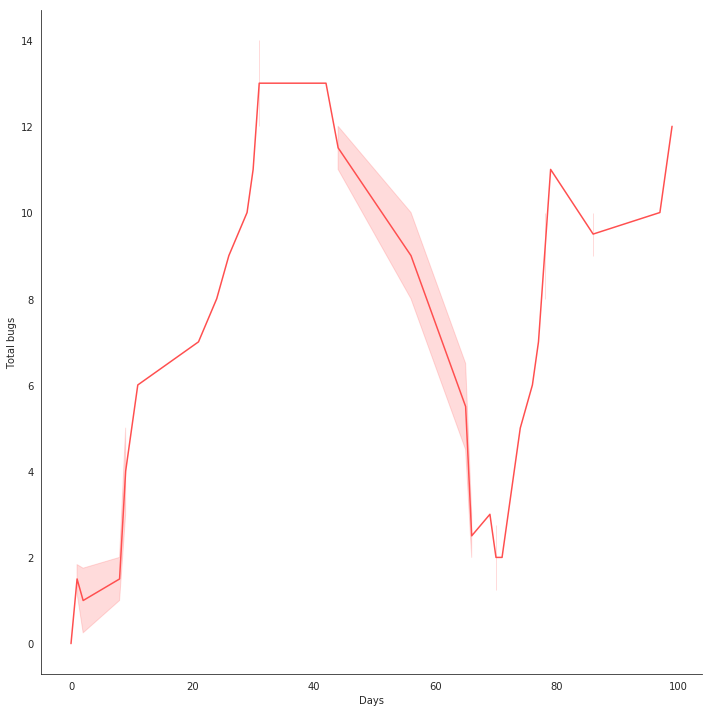

In [21]:
#@title Show results of the simulation

# print(day_of_simulation)
# print(total_bugs_of_simulation,"\n")

print_stats(total_bugs_of_simulation)
plot_two_lists('Days', day_of_simulation, 'Total bugs', 
               total_bugs_of_simulation, 'line', 
               10)

### Creation vs Resolution

In [0]:
#@markdown ### Enter how many days to simulate
how_many_days = 100 #@param {type:"integer"}

#@markdown ### Enter the number of active developers
how_many_developers = 500 #@param {type:"integer"}

In [0]:
# @title Simulation of "creation_vs_resolution"

day_of_simulation = []
total_bugs_of_simulation = []

class BugSimulation(object):
  def __init__(self, env, bcs):
    self.total_bugs = 0
    self.total_bugs_fixed = 0
    self.active_devs = 0
    
    self.env = env
    self.bcs = bcs
    
    self.env.process(self.bug_creation())
    self.save_info()
  
  def bug_creation(self):
    while True:
      # create bug creation time to wait
      bug_creation_time = self.ecdf_random_number(ecdf_probablity_distribution_bc)
#       print("C",bug_creation_time, "at", self.env.now)
      yield self.env.timeout(bug_creation_time)
      
      # save information
      self.total_bugs += 1
      self.save_info()
      
      # launch a developer
      self.env.process(self.bug_resolution())
    
    
  def bug_resolution(self):
    with self.bcs.request() as req:
      yield req
      
      self.active_devs += 1
      bug_resolution_time = self.ecdf_random_number(ecdf_probablity_distribution_br)
#       print("F", bug_resolution_time, "D", self.active_devs, "at", self.env.now)
      yield self.env.timeout(bug_resolution_time)

      self.total_bugs -= 1
      self.active_devs -= 1
      self.total_bugs_fixed += 1
      
      self.save_info()

  def save_info(self):
    day_of_simulation.append(self.env.now)
    total_bugs_of_simulation.append(self.total_bugs)
      
      
  def ecdf_random_number(self, data):
    rand = random.uniform(0, 1)
    # get the position from bisecting
    pos = bisect_left(data, rand)
    
    # manually first and last to avoid exception error further on
    if pos == 0 or pos == len(data): return pos
    
    # return the closest between two
    before = data[pos-1]
    after = data[pos]
    if after - rand < rand - before: return pos # after
    else: return pos-1 # before
  
  def return_info(self):
    return self.total_bugs_fixed
    

if use_theoretical_models == True:
  print("Doesn't support theoretical models.")

env = simpy.Environment()
bcs = simpy.Resource(env, capacity=how_many_developers)
bug_simulation = BugSimulation(env, bcs)
env.run(until=how_many_days)

Total bugs fixed: 27 

Max: 9
Min: 0

Mean: 6.11
Median: 7.0
Mode: 7


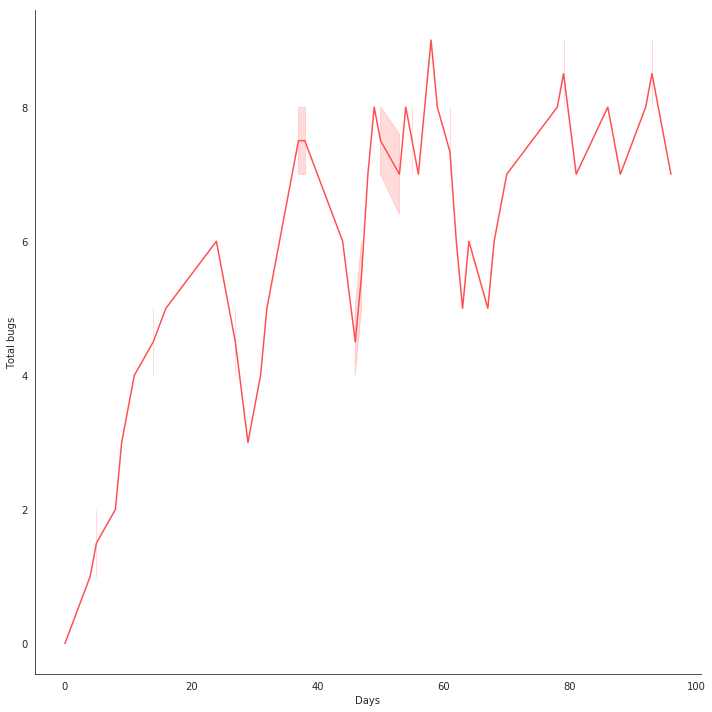

In [24]:
#@title Show results of the simulation
# print(day_of_simulation)
# print(total_bugs_of_simulation,"\n")

print("Total bugs fixed:", bug_simulation.return_info(), "\n")
print_stats(total_bugs_of_simulation)
plot_two_lists('Days', day_of_simulation, 'Total bugs', 
               total_bugs_of_simulation, 'line', 
               10)

In [0]:
#@markdown Playing with the code

# # np.random.choice(np.arange(1, 7), p=[0.1, 0.05, 0.05, 0.2, 0.4, 0.2])

# # rvs(c, loc=0, scale=1, size=1, random_state=None)
# value = st.genpareto.rvs(6.31, loc=0, scale=2.95, size=1)
# print(value, int(value))

# # rvs(beta, loc=0, scale=1, size=1, random_state=None)
# value = st.halfgennorm.rvs(0.34, loc=0, scale=0.02, size=1)
# print(value, int(value))




# def car(env):
#   while True:
#     print('Start parking at %d' % env.now)
#     parking_duration = 5
#     yield env.timeout(parking_duration)

#     print('Start driving at %d' % env.now)
#     trip_duration = 2
#     yield env.timeout(trip_duration)

# env = simpy.Environment()
# env.process(car(env))
# env.run(until=15)




# class Car(object):
#   def __init__(self, env):
#       self.env = env
      
#       self.action = env.process(self.run())

#   def run(self):
#       while True:
#           print('Start parking and charging at %d' % self.env.now)
#           charge_duration = 5
#           # We may get interrupted while charging the battery
#           try:
#               yield self.env.process(self.charge(charge_duration))
#           except simpy.Interrupt:
#               # When we received an interrupt, we stop charging and
#               # switch to the "driving" state
#               print('Was interrupted. Hope, the battery is full enough ...')

#           print('Start driving at %d' % self.env.now)
#           trip_duration = 2
#           yield self.env.timeout(trip_duration)

#   def charge(self, duration):
#       yield self.env.timeout(duration)

# def driver(env, car):
#     yield env.timeout(3)
#     car.action.interrupt()
      
# env = simpy.Environment()
# car = Car(env)

# env.process(driver(env, car))
# env.run(until=25)




# # Arrival rate and length of stay inputs.
# ARR_RATE = 0.4
# MEAN_LOS_OBS = 3
# MEAN_LOS_LDR = 12
# MEAN_LOS_PP = 48

# RNG_SEED = 6354

# def source(env, arr_rate, prng=RandomState(0)):
#     patients_created = 0

#     # Infinite loop for generating patients according to a poisson process.
#     while True:

#         # Generate next interarrival time
#         iat = prng.exponential(1.0 / arr_rate)

#         # Generate length of stay in each unit for this patient
#         los_obs = prng.exponential(MEAN_LOS_OBS)
#         los_ldr = prng.exponential(MEAN_LOS_LDR)
#         los_pp = prng.exponential(MEAN_LOS_PP)

#         # Update counter of patients
#         patients_created += 1

#         # Create a new patient flow process.
#         obp = obpatient_flow(env, 'Patient {}'.format(patients_created),
#                              los_obs=los_obs, los_ldr=los_ldr, los_pp=los_pp)

#         # Register the process with the simulation environment
#         env.process(obp)

#         # This process will now yield to a 'timeout' event. This process will resume after iat time units.
#         yield env.timeout(iat)

# # Define an obpatient_flow "process"
# def obpatient_flow(env, name, los_obs, los_ldr, los_pp):

#     # Note how we are simply modeling each stay as a delay. There
#     # is NO contention for any resources.
#     print("{} entering OBS at {:.4f}".format(name, env.now))
#     yield env.timeout(los_obs)

#     print("{} entering LDR at {:.4f}".format(name, env.now))
#     yield env.timeout(los_ldr)

#     print("{} entering PP at {:.4f}".format(name, env.now))
#     yield env.timeout(los_pp)


# # Initialize a simulation environment
# env = simpy.Environment()

# # Initialize a random number generator.
# # See https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.RandomState.html
# prng = RandomState(RNG_SEED)

# # Create a process generator and start it and add it to the env
# # Calling obpatient(env) creates the generator.
# # env.process() starts and adds it to env
# runtime = 25
# env.process(source(env, ARR_RATE, prng))

# # Run the simulation
# env.run(until=runtime)